In [11]:
import numpy as np
from PIL import Image
import os
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns

## Pre-procesamiento de imágenes

Función para convertir imágenes a vectores normalizados en escala de grises:

In [12]:
def image_convert(dir, new_size):

    imagenes = []

    for filename in os.listdir(dir):

        file_path = os.path.join(dir, filename)
        
        if os.path.isfile(file_path):

            # Sin este if no funciona en mi windows, probar comentarlo en Mac a ver que pasa
            if not filename.lower().endswith('.png'):
                continue
            try:
                with Image.open(file_path) as img:
                    img = img.resize(new_size) 
                    img = img.convert('L') # Convertir a escala de grises
                    img_array = np.array(img)/255.0 # Convertir a array y normalizar
                    img_vector = img_array.reshape((new_size[0]**2)) 
                    imagenes.append(img_vector)
            except Exception as e:
                print(f"Error procesando la imagen {file_path}: {e}")

    return np.array(imagenes)


Configuramos los tamaños y elegimos aquel que se utilizará para los experimentos:

In [13]:
original = (256, 256)
mediano =  (128, 128)
chico = (64, 64)
muy_chico = (32, 32)

size = mediano

In [14]:
# Healthy
src_dir = 'DatasetTP/Healthy'
i_healthy = image_convert(src_dir, size) # Imágenes de pacientes sanos
d_healthy = np.ones((i_healthy.shape[0], 1)) * 0 # Vector de diagnósticos para la gente sana (0)

# Parkinson
src_dir = 'DatasetTP/Parkinson'  
i_park = image_convert(src_dir, size) # Imágenes de pacientes con Parkinson
d_park = np.ones((i_park.shape[0], 1)) # Vector de diagnósticos para la gente con Parkinson (1)

cant_healthy = i_healthy.shape[0] # Cantidad de imágenes sanas
print(f"Cantidad de imágenes sanas: {cant_healthy}")

cant_park = i_park.shape[0] # Cantidad de imágenes con Parkinson
print(f"Cantidad de imágenes con Parkinson: {cant_park}")

print(f"Tamaño de las imágenes: {size} = {size[0] * size[1]} pixeles")

Cantidad de imágenes sanas: 816
Cantidad de imágenes con Parkinson: 816
Tamaño de las imágenes: (128, 128) = 16384 pixeles


Separamos en conjuntos de entrenamiento y test:

In [15]:
cant_healthy_train = round(cant_healthy * 0.5) # 70% de las imágenes sanas para entrenamiento
cant_healthy_test = cant_healthy - cant_healthy_train # 30% de las imágenes sanas para test

cant_park_train = round(cant_park * 0.5) # 70% de las imágenes con Parkinson para entrenamiento
cant_park_test = cant_park - cant_park_train # 30% de las imágenes con Parkinson para test

print(f"Entrenamiento - Sanos: {cant_healthy_train}, Parkinson: {cant_park_train}")
print(f"Test - Sanos: {cant_healthy_test}, Parkinson: {cant_park_test}")

# Dividimos las imágenes en entrenamiento y test
i_train = np.vstack((i_healthy[:cant_healthy_train], i_park[:cant_park_train])) # Imágenes de entrenamiento
d_train = np.vstack((d_healthy[:cant_healthy_train], d_park[:cant_park_train])) # Diagnósticos de entrenamiento

i_test = np.vstack((i_healthy[cant_healthy_train:], i_park[cant_park_train:])) # Imágenes de test
d_test = np.vstack((d_healthy[cant_healthy_train:], d_park[cant_park_train:])) # Diagnósticos de test

print(f"Entrenamiento: {i_train.shape}, {d_train.shape}")
print(f"Test: {i_test.shape}, {d_test.shape}")

# Mezclo los datos de entrenamiento y test
np.random.seed(42)  
indices = np.random.permutation(i_train.shape[0])
i_train = i_train[indices]
d_train = d_train[indices]

indices = np.random.permutation(i_test.shape[0])
i_test = i_test[indices]
d_test = d_test[indices]

# Chequeamos que la intersección entre train y test sea nula (Importante)
print(len(set(map(tuple, i_train)).intersection(map(tuple, i_test))) == 0)


Entrenamiento - Sanos: 408, Parkinson: 408
Test - Sanos: 408, Parkinson: 408
Entrenamiento: (816, 16384), (816, 1)
Test: (816, 16384), (816, 1)
True


Queremos minimizar la función de pérdida:

$$
\sum_{i=1}^{N} \left( f^*(\mathbf{i}_i) - d_i \right)^2
$$

Es decir, queremos minimizar la diferencia entre los diagnósticos que predice el modelo y los reales. 

Buscamos la mejor solución dentro de las funciones $f : \mathbb{R}^K \to (0, 1)$
 que tengan la forma:

$$
f_{\mathbf{w}, b}(\mathbf{i}) = \frac{\tanh(\mathbf{w} \cdot \mathbf{i} + b) + 1}{2}
$$


donde $w$ es un vector de pesos (weights) de $\mathbb{R}^K$ , $b$ (bias) un escalar, y $tanh$ la tangente hiperbólica.

## Parte 1: Descenso de gradiente

$$
\arg\min_{\mathbf{w}, b} \mathcal{L}(\mathbf{w}, b) = 
\arg\min_{\mathbf{w}, b} \sum_{i=1}^{N} \left( f_{\mathbf{w}, b}(\mathbf{i}_i) - d_i \right)^2
$$

Derivamos $\mathcal{L}$ con respecto a $b$ (bias) y $w$ (weight):

$$
\frac{\partial \mathcal{L}(\mathbf{w}, b) }{\partial w} = (1-\tanh(b+w^\top \cdot i)^{2})\cdot ((1+\tanh(b+w^\top \cdot i))/2-d)\cdot i
$$

$$
\frac{\partial \mathcal{L}(\mathbf{w}, b) }{\partial b} = (1-\tanh(b+w^\top \cdot i)^{2})\cdot ((1+\tanh(b+w^\top \cdot i))/2-d)
$$

Funciones base:

In [16]:
def fwb_desc(i, w, b):
    z = i@w + b 
    f = (np.tanh(z) + 1) / 2 
    return f 

In [17]:
# Error cuadrático medio
def funcion_objetivo_desc(w, b, i, d):
    f = fwb_desc(i, w, b)
    rss = np.sum((f - d) ** 2)
    # return rss / i.shape[0]  # Promedio del RSS
    return rss

In [18]:
# Derivada parcial respecto a w
def df_w_desc(w, b, i, d):
    # f = fwb_desc(i, w, b)
    z = i @ w + b
    f = (np.tanh(z) + 1) / 2
    dz = (1 - np.tanh(z) ** 2) * (f - d)  
    grad_w = i.T @ dz                  
    return grad_w

In [19]:
# Derivada parcial respecto a b
def df_b_desc(w, b, i, d):
    # f = fwb_desc(i, w, b)
    z = i @ w + b
    f = (np.tanh(z) + 1) / 2
    dz = (1 - np.tanh(z) ** 2) * (f - d)
    # grad_b = np.sum(dz, axis=0, keepdims=True)  # Da forma (1,1)
    grad_b = np.sum(dz) 
    return grad_b

In [20]:
def accuracy_desc(i, d, w, b):
    f = fwb_desc(i, w, b) 
    y_hat = (f >= 0.5).astype(int)  
    d = d.astype(int)  
    return np.mean(y_hat == d) * 100  

## Descenso de gradiente

In [21]:
MAX_ITER = 1000

TOLERANCIA = 1e-7 

def gradient_descent(w, b, imagenes, diagnosticos, alpha=0.1, normalizar=False):
    
    if normalizar:
      imagenes = imagenes / np.max(imagenes)

    iter  = 0
    valores_loss = [] 
    accuracy = []

    while iter <= MAX_ITER:
        
        loss = funcion_objetivo_desc(w, b, imagenes, diagnosticos)
        # print("Iteración: ", iter, "- Mínimo: ", loss)

        valores_loss.append(loss)
        accuracy.append(accuracy_desc(imagenes, diagnosticos, w, b))
        
        gradiente_w = df_w_desc(w, b, imagenes, diagnosticos) 
        gradiente_b = df_b_desc(w, b, imagenes, diagnosticos)

        # Control de norma del gradiente
        max_norm = 100.0
        norm_w = np.linalg.norm(gradiente_w)
        if norm_w > max_norm:
            gradiente_w = gradiente_w * (max_norm / norm_w)

    
        # # Si gradiente_b no es escalar, colapsar con promedio o suma
        if gradiente_b.ndim > 0 and gradiente_b.size > 1:
          gradiente_b = np.mean(gradiente_b)  # O np.sum(gradiente_b)

        # Actualización 
        w_sig = w - alpha * gradiente_w
        b_sig = b - alpha * gradiente_b

        # Criterio de convergencia
        criterio = np.abs(funcion_objetivo_desc(w_sig, b_sig, imagenes, diagnosticos) - funcion_objetivo_desc(w, b, imagenes, diagnosticos))

        if criterio < TOLERANCIA:
          print("Criterio de convergencia alcanzado en iteración", iter)
          break

        w = w_sig
        b = b_sig
        iter += 1

    return w_sig, b_sig, valores_loss, accuracy

## Entrenamiento

In [22]:
w = np.random.uniform(-1, 1, (i_train.shape[1], 1)) * 0.01
b = np.random.uniform(-1, 1) * 0.01
alpha = 1e-7
normalizar = False

w_optimo, b_optimo, valores_loss_train, accuracy_train = gradient_descent(w, b, i_train, d_train, alpha, normalizar)

# Cálculo de TP, TN, FP y FN para ENTRENAMIENTO

z = i_train @ w_optimo + b_optimo
y_hat = (np.tanh(z) + 1) / 2
y_hat_labels = (y_hat >= 0.5).astype(int)
d_true = d_train.astype(int)

TP_desc_train = np.sum((y_hat_labels == 1) & (d_true == 1))
TN_desc_train = np.sum((y_hat_labels == 0) & (d_true == 0))
FP_desc_train = np.sum((y_hat_labels == 1) & (d_true == 0))
FN_desc_train = np.sum((y_hat_labels == 0) & (d_true == 1))

In [23]:
# Matriz de confusión

# TP_pct = TP_desc_train / cant_park_train * 100 #sobre el total de gente enferma
# TN_pct = TN_desc_train / cant_park_train * 100 #sobre el total de gente sana
# FP_pct = FP_desc_train / cant_park_train * 100 #sobre el total de gente sana
# FN_pct = FN_desc_train / cant_park_train * 100 #sobre el total de gente enferma

# conf_matrix_desc = np.array([[TN_pct, FP_pct],[FN_pct, TP_pct]])


# labels = np.array([["True Negative", "False Positive"],
#                    ["False Negative", "True Positive"]])

# # Generamos texto para cada celda con etiqueta y valor porcentual
# annot = np.empty_like(conf_matrix_desc).astype(str)
# for i in range(conf_matrix_desc.shape[0]):
#     for j in range(conf_matrix_desc.shape[1]):
#         annot[i, j] = f"{labels[i, j]}\n{conf_matrix_desc[i, j]:.2f}%"

# plt.figure(figsize=(8,6))
# sns.heatmap(conf_matrix_desc, annot=annot, fmt='', cmap="coolwarm",
#             xticklabels=["Pred: Sano", "Pred: Parkinson"],
#             yticklabels=["Real: Sano", "Real: Parkinson"],
#             cbar=False)

# plt.title("Matriz de Confusión")
# plt.ylabel("Realidad")
# plt.xlabel("Predicción")
# plt.show()

In [24]:
print(f"Máxima accuracy en entrenamiento: {max(accuracy_train)}")
print(f"Mínima accuracy en entrenamiento: {min(accuracy_train)}")

Máxima accuracy en entrenamiento: 53.92156862745098
Mínima accuracy en entrenamiento: 49.63235294117647


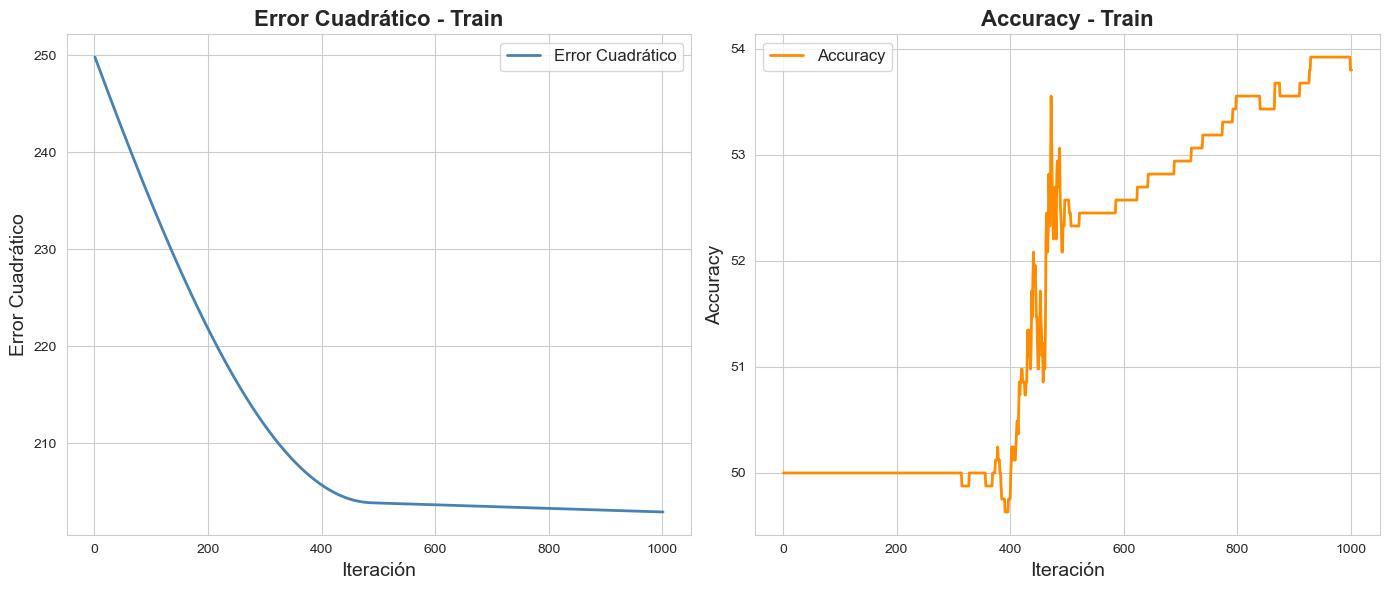

In [25]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Error cuadrático
sns.lineplot(x=np.arange(1, len(valores_loss_train)+1), y=valores_loss_train, ax=axes[0], color='steelblue', linewidth=2, label='Error Cuadrático')
axes[0].set_title('Error Cuadrático - Train', fontsize=16, weight='bold')
axes[0].set_xlabel('Iteración', fontsize=14)
axes[0].set_ylabel('Error Cuadrático', fontsize=14)
axes[0].legend(fontsize=12)

# Accuracy
sns.lineplot(x=np.arange(1, len(accuracy_train)+1), y=accuracy_train, ax=axes[1], color='darkorange', linewidth=2, label='Accuracy')
axes[1].set_title('Accuracy - Train', fontsize=16, weight='bold')
axes[1].set_xlabel('Iteración', fontsize=14)
axes[1].set_ylabel('Accuracy', fontsize=14)
axes[1].legend(fontsize=12)

plt.tight_layout()
plt.show()

## Testeo

In [26]:
w = np.random.uniform(-1, 1, (i_test.shape[1], 1)) * 0.01
b = np.random.uniform(-1, 1) * 0.01
alpha = 1e-7
normalizar = False

w_optimo, b_optimo, valores_loss_test, accuracy_test = gradient_descent(w, b, i_test, d_test, alpha, normalizar)

# Cálculo de TP, TN, FP y FN para TEST

z = i_test @ w_optimo + b_optimo
y_hat = (np.tanh(z) + 1) / 2
y_hat_labels = (y_hat >= 0.5).astype(int)
d_true = d_test.astype(int)

TP_desc_test = np.sum((y_hat_labels == 1) & (d_true == 1))
TN_desc_test = np.sum((y_hat_labels == 0) & (d_true == 0))
FP_desc_test = np.sum((y_hat_labels == 1) & (d_true == 0))
FN_desc_test = np.sum((y_hat_labels == 0) & (d_true == 1))

In [27]:
print(f"Máxima accuracy en testeo: {max(accuracy_test)}")
print(f"Mínima accuracy en testeo: {min(accuracy_test)}")

Máxima accuracy en testeo: 53.92156862745098
Mínima accuracy en testeo: 49.50980392156863


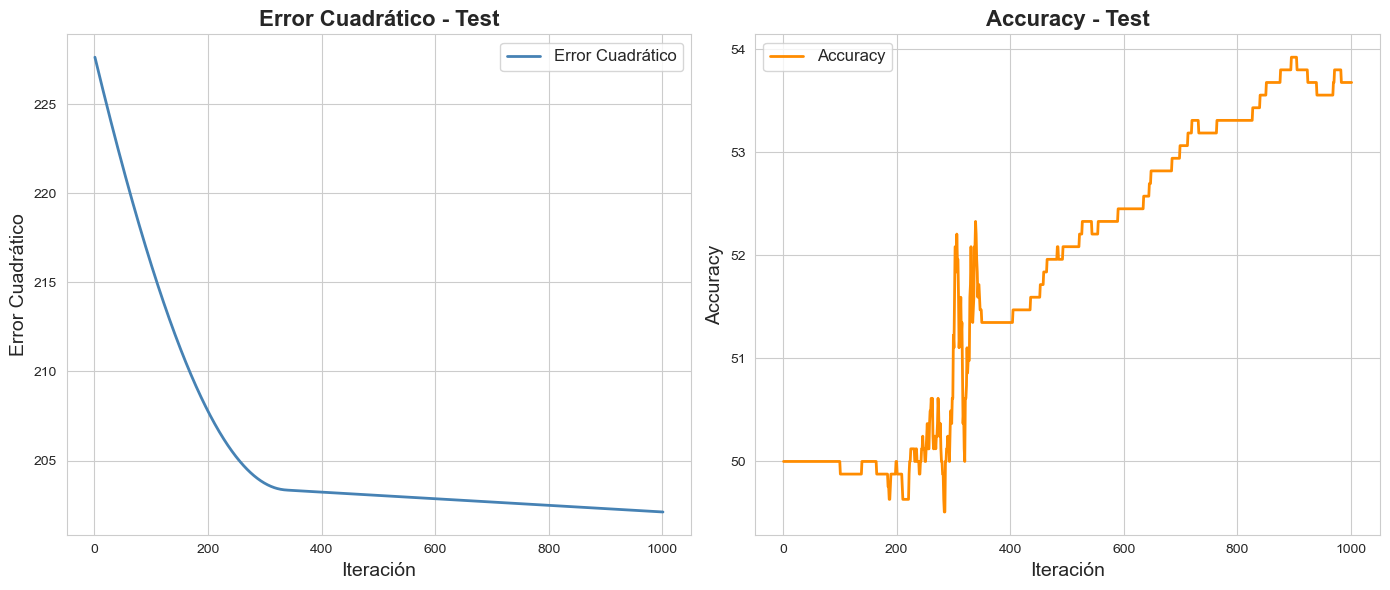

In [28]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Error cuadrático
sns.lineplot(x=np.arange(1, len(valores_loss_test)+1), y=valores_loss_test, ax=axes[0], color='steelblue', linewidth=2, label='Error Cuadrático')
axes[0].set_title('Error Cuadrático - Test', fontsize=16, weight='bold')
axes[0].set_xlabel('Iteración', fontsize=14)
axes[0].set_ylabel('Error Cuadrático', fontsize=14)
axes[0].legend(fontsize=12)

# Accuracy
sns.lineplot(x=np.arange(1, len(accuracy_test)+1), y=accuracy_test, ax=axes[1], color='darkorange', linewidth=2, label='Accuracy')
axes[1].set_title('Accuracy - Test', fontsize=16, weight='bold')
axes[1].set_xlabel('Iteración', fontsize=14)
axes[1].set_ylabel('Accuracy', fontsize=14)
axes[1].legend(fontsize=12)

plt.tight_layout()
plt.show()

In [29]:
# plt.figure(figsize=(12, 6))
# sns.set_style("whitegrid")  
# iteraciones = np.arange(1, len(valores_loss_test) + 1)
# sns.lineplot(x=iteraciones, y=valores_loss_test, color='seagreen', linewidth=2, markersize=5)
# tick_interval = max(1, len(valores_loss_test) // 20)
# plt.xticks(np.arange(1, len(valores_loss_test) + 1, step=tick_interval))
# plt.xlabel('Iteración', fontsize=14)
# plt.ylabel('Valor de la función objetivo', fontsize=14)
# plt.title('Convergencia de GD con datos de test', fontsize=16, weight='bold')
# plt.legend(['Función objetivo (loss)'], fontsize=12)
# plt.tight_layout()
# plt.show()

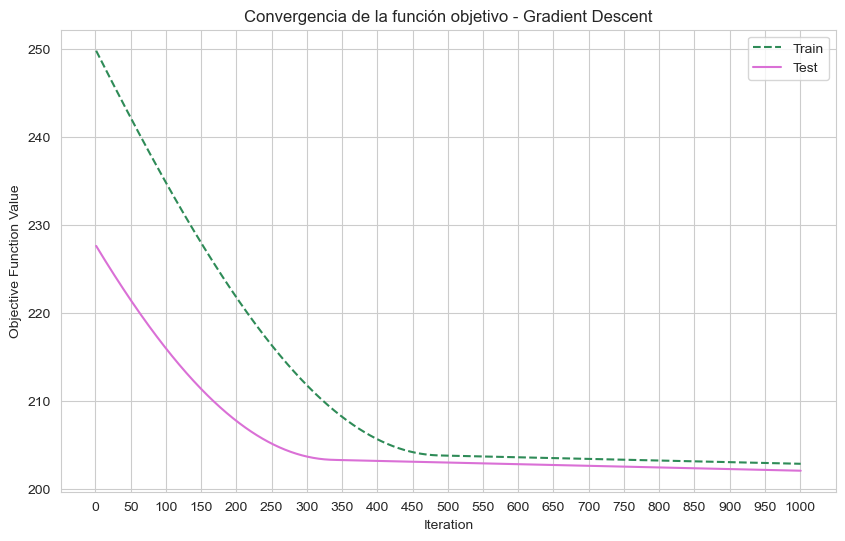

In [30]:
plt.figure(figsize=(10, 6))

plt.plot(np.arange(1, len(valores_loss_train) + 1), valores_loss_train, linestyle='--', color='seagreen', label='Train')

plt.plot(np.arange(1, len(valores_loss_test) + 1), valores_loss_test, linestyle='-', color='orchid', label='Test')

tick_interval = max(1, len(valores_loss_train) // 20)
plt.xticks(np.arange(0, len(valores_loss_train) + 1, step=tick_interval))

plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Convergencia de la función objetivo - Gradient Descent')
plt.grid(True)
plt.legend()  
plt.show()

## Parte 2: Ascenso de gradiente

$$

\arg\min_{\mathbf{w}, b} \mathcal{L}(\mathbf{w}, b) = - \sum_{i=1}^{N} \left[ d_i \log\left( f_{\mathbf{w}, b}(\mathbf{i} * i) \right) + (1 - d_i) \log\left( 1 - f * \mathbf{w}, b(\mathbf{i}_i) \right) \right]


$$

In [31]:
def fwb_asc(i, w, b):
    z = i@w + b 
    f = 1 / (1 + np.exp(-z))  
    return f

In [45]:
def funcion_objetivo_asc(w, b, i, d):
    f = fwb_asc(i, w, b)
    epsilon = 1e-15
    f = np.clip(f, epsilon, 1 - epsilon)
    return -np.sum(d * np.log(f) + (1 - d) * np.log(1 - f))  

In [33]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [34]:
def df_w_asc(w, b, i, d):
    z = i @ w + b                
    f = sigmoid(z)              
    error = f - d                
    grad_w = i.T @ error         
    return grad_w

In [35]:
def df_b_asc(w, b, i, d):
    z = i @ w + b       
    f = sigmoid(z)      
    error = f - d       
    grad_b = np.sum(error)  
    return grad_b

In [40]:
def accuracy_asc(i, d, w, b):
    f = fwb_asc(i, w, b) 
    y_hat = (f >= 0.5).astype(int)  
    d = d.astype(int)  
    return np.mean(y_hat == d) * 100  

In [65]:
MAX_ITER = 1000

TOLERANCIA = 1e-7 

def grad_asc(w, b, imagenes, diagnosticos, alpha):

    imagenes = imagenes / np.max(imagenes)
    # imagenes = (imagenes - np.mean(imagenes)) / np.std(imagenes)


    iter = 0
    valores_logv = []
    accuracy = []

    while iter <= MAX_ITER:
    
        log_v = funcion_objetivo_asc(w, b, imagenes, diagnosticos)
        valores_logv.append(log_v)  
        accuracy.append(accuracy_asc(imagenes, diagnosticos, w, b))

        if iter % 50 == 0:
            print(f"Iter {iter} - LogVeros: {log_v:.4f} - Accuracy: {accuracy[-1]:.4f}")

        gradiente_w = df_w_asc(w, b, imagenes, diagnosticos)
        gradiente_b = df_b_asc(w, b, imagenes, diagnosticos)

        # Normalización del gradiente si es necesario
        max_norm = 100.0
        norm_w = np.linalg.norm(gradiente_w)
        if norm_w > max_norm:
            gradiente_w = gradiente_w * (max_norm / norm_w)

        if gradiente_b.ndim > 0 and gradiente_b.size > 1:
            gradiente_b = np.mean(gradiente_b)

        # Ascenso
        w_sig = w + alpha * gradiente_w
        b_sig = b + alpha * gradiente_b

        # Convergencia (comparando la pérdida real, no el negativo)
        criterio = np.abs(funcion_objetivo_asc(w_sig, b_sig, imagenes, diagnosticos) -
                          funcion_objetivo_asc(w, b, imagenes, diagnosticos))

        if criterio < TOLERANCIA:
            print("Criterio de convergencia alcanzado en iteración", iter)
            break

        w = w_sig
        b = b_sig
        iter += 1

    return w_sig, b_sig, valores_logv, accuracy


In [66]:
w = np.random.uniform(-1, 1, (i_train.shape[1], 1)) * 0.01
b = np.random.uniform(-1, 1) * 0.01
alpha = 1e-5

w_optimo, b_optimo, valores_logv_train, accuracy_train_asc = grad_asc(w, b, i_train, d_train, alpha)

# Cálculo de TP, TN, FP y FN para ENTRENAMIENTO

# z = i_train @ w_optimo + b_optimo
# y_hat = (np.tanh(z) + 1) / 2
# y_hat_labels = (y_hat >= 0.5).astype(int)
# d_true = d_train.astype(int)

# TP_asc_train = np.sum((y_hat_labels == 1) & (d_true == 1))
# TN_asc_train = np.sum((y_hat_labels == 0) & (d_true == 0))
# FP_asc_train = np.sum((y_hat_labels == 1) & (d_true == 0))
# FN_asc_train = np.sum((y_hat_labels == 0) & (d_true == 1))
# Verificá predicciones finales
# z = i_train @ w_optimo + b_optimo
# f = 1 / (1 + np.exp(-z))  # sigmoid
# y_pred = (f >= 0.5).astype(int)

# print("Predicciones:", np.unique(y_pred, return_counts=True))

z = i_train @ w_optimo + b_optimo
f = 1 / (1 + np.exp(-z))

print("f (predicciones sigmoid): min =", np.min(f), "max =", np.max(f))



Iter 0 - LogVeros: 801.3391 - Accuracy: 50.0000
Iter 50 - LogVeros: 2862.7340 - Accuracy: 50.0000
Iter 100 - LogVeros: 5083.1750 - Accuracy: 50.0000
Iter 150 - LogVeros: 7304.5895 - Accuracy: 50.0000
Iter 200 - LogVeros: 9526.0102 - Accuracy: 50.0000
Iter 250 - LogVeros: 11747.3723 - Accuracy: 50.0000
Iter 300 - LogVeros: 13337.2074 - Accuracy: 50.0000
Criterio de convergencia alcanzado en iteración 344
f (predicciones sigmoid): min = 0.999999999999998 max = 1.0


In [60]:
print("Max de imágenes:", np.max(i_train))
print("Min de imágenes:", np.min(i_train))


Max de imágenes: 1.0
Min de imágenes: 0.058823529411764705


In [53]:
valores, conteos = np.unique(d_train, return_counts=True)
for v, c in zip(valores, conteos):
    print(f"Etiqueta {v}: {c} ejemplos")


Etiqueta 0.0: 408 ejemplos
Etiqueta 1.0: 408 ejemplos


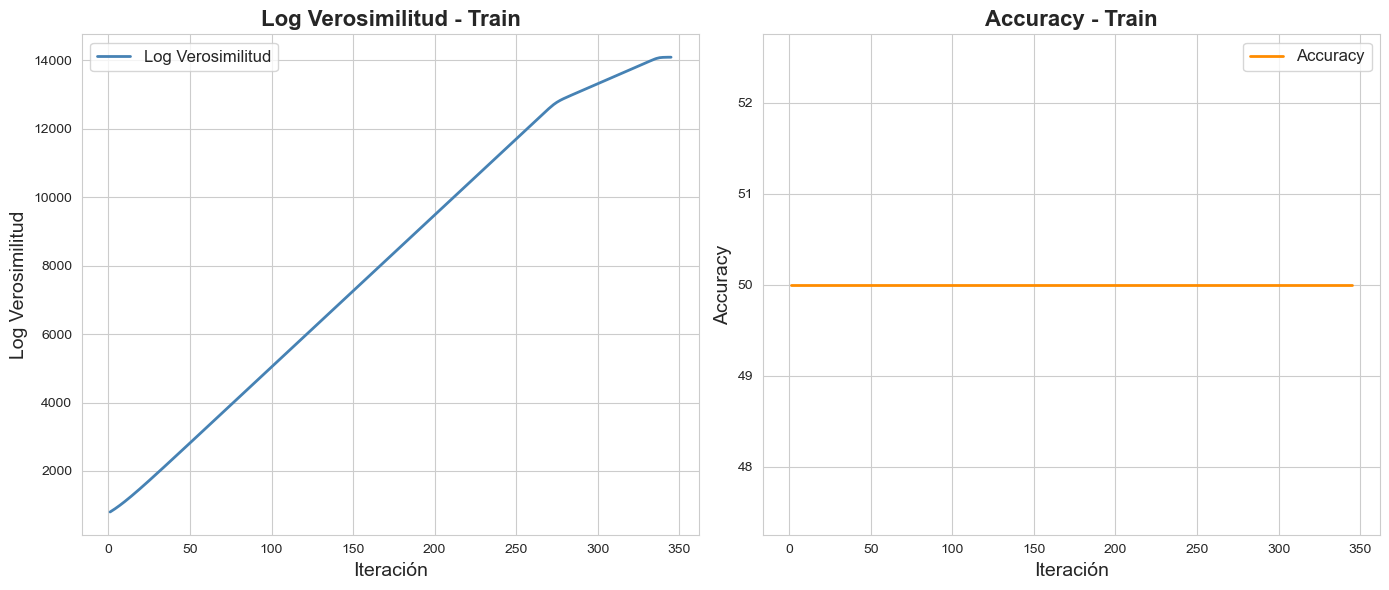

In [67]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Error cuadrático
sns.lineplot(x=np.arange(1, len(valores_logv_train)+1), y=valores_logv_train, ax=axes[0], color='steelblue', linewidth=2, label='Log Verosimilitud')
axes[0].set_title('Log Verosimilitud - Train', fontsize=16, weight='bold')
axes[0].set_xlabel('Iteración', fontsize=14)
axes[0].set_ylabel('Log Verosimilitud', fontsize=14)
axes[0].legend(fontsize=12)

# Accuracy
sns.lineplot(x=np.arange(1, len(accuracy_train_asc)+1), y=accuracy_train_asc, ax=axes[1], color='darkorange', linewidth=2, label='Accuracy')
axes[1].set_title('Accuracy - Train', fontsize=16, weight='bold')
axes[1].set_xlabel('Iteración', fontsize=14)
axes[1].set_ylabel('Accuracy', fontsize=14)
axes[1].legend(fontsize=12)

plt.tight_layout()
plt.show()